In [39]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [40]:
# query =\
# '''
# -- query for clustering v2
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT 
#     user_id, 
#     date_,
#     kyc_tier,
#     loyalty_tier,
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , campaigns AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(daily_OTHER_saldo) AS M1_campaign_saldo
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )


# , payments AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     -- TRANSACTIONS
#     COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
#     COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
#     -- CUSTOMER
#     COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
#   FROM `ledger-fcc1e.payment_reports.payments_ssot`
#   WHERE
#     status_v2 = 'COMPLETED'
#     AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# , accountings AS (
#   SELECT DISTINCT
#     DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
#     createdByUser AS user_id,
#     COUNT(DISTINCT transactionId) AS M1_acc_count
#   FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
#   WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# -- //this is a bit inefficient since i load the same table twice...
# -- //open to idea on how to do it better
# -- , banks AS (
# --   SELECT DISTINCT
# --     user_id,
# --     date_,
# --     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
# --   FROM (
# --     SELECT 
# --       user_id,
# --       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
# --       money_in_channel,
# --       COUNT(*) AS cnt_
# --     FROM `ledger-fcc1e.payment_reports.payments_ssot`
# --     WHERE
# --       status_v2 = 'COMPLETED'
# --       AND product_type IN ('SALDO')
# --       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
# --     GROUP BY 1, 2, 3
# --   )
# -- )

# , referrals AS (
#   SELECT 
#     referrer AS user_id,
#     date_,
#     COUNT(DISTINCT referee) AS referee_count
#   FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
#   WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#   GROUP BY 1, 2
# )

# , profiles AS (
#   SELECT DISTINCT
#     user_id,
#     acquisition_channel,
#     user_segment_sub_bucket,
#     first_user_date,
#     first_any_payment_date,
#     first_transaction_date
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-04-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT DISTINCT
#   user_id,
#   date_,
#   kyc_tier,
#   loyalty_tier,
#   (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
#   (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
#   (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
#   M1_campaign_saldo,
#   -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
#   -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
#   -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
#   -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
#   total_customer,
#   -- IFNULL(
#   --   IFNULL(
#   --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
#   --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
#   --   ),
#   --   NULL
#   -- ) AS main_funding_bank,
#   (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
#   acquisition_channel,
#   user_segment_sub_bucket,
#   DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
#   IFNULL(activated_count, 0) AS is_act_m1,
#   IFNULL(converted_count, 0) AS is_conv_m1
# FROM users -- active in last 12 months
# INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
# LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
# -- LEFT JOIN banks USING (user_id, date_)
# LEFT JOIN referrals USING (user_id, date_)
# LEFT JOIN impressions USING (user_id, date_)
# LEFT JOIN accountings USING (user_id, date_)
# LEFT JOIN campaigns USING (user_id, date_)
# LEFT JOIN profiles USING (user_id)
# WHERE date_ < '2023-09-01'
# ORDER BY 1, 2

# '''
# raw = client.query(query).result().to_dataframe()
# raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [41]:
# -- QUERY TO GET IMPRESSIONS COUNT
# imp_query =\
# '''
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT user_id, date_
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_TRUNC(notification_date, MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-05-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT
#   user_id,
#   date_,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
#   IFNULL(activated_count, 0) AS activated_count,
#   IFNULL(converted_count, 0) AS conveted_count
# FROM users
# INNER JOIN loyalty USING (user_id)
# LEFT JOIN impressions USING (user_id, date_)
# WHERE send_count IS NOT NULL
# '''
# imp = client.query(imp_query).result().to_dataframe()
# imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [42]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202898 entries, 0 to 202897
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202898 non-null  object
 1   date_                    202898 non-null  dbdate
 2   kyc_tier                 202898 non-null  object
 3   loyalty_tier             202898 non-null  object
 4   M1_core_count            148403 non-null  Int64 
 5   M1_ppob_count            148403 non-null  Int64 
 6   M1_acc_count             201373 non-null  Int64 
 7   M1_campaign_saldo        202743 non-null  Int64 
 8   total_customer           87924 non-null   Int64 
 9   is_referrer              202898 non-null  Int64 
 10  acquisition_channel      202898 non-null  object
 11  user_segment_sub_bucket  202898 non-null  object
 12  age_on_platform_days     202898 non-null  Int64 
 13  is_send_m1               202898 non-null  Int64 
 14  is_imp_m1           

In [43]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        # M1_core_count = lambda x: np.log1p(x.M1_core_count),
        # M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        # M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        # M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        # age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_act_m1', 'is_conv_m1', 'M1_campaign_saldo', 'M1_acc_count'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1
index_,,,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0,1,1,0,Organic Acquisition,pureO2O-PA+PP,309,0,0,0
1161895687 2023-07-01,ADVANCED,Bronze,0,2,2,0,Organic Acquisition,pureO2O-PA+PP,339,0,0,0
1161895687 2023-08-01,ADVANCED,Bronze,0,22,16,0,Organic Acquisition,pureO2O-PA+PP,370,0,0,0
8111010474 2023-05-01,ADVANCED,Bronze,0,0,<NA>,0,Paid Acquisition,UNKNOWN,398,0,0,0
8111010474 2023-06-01,ADVANCED,Bronze,0,0,<NA>,0,Paid Acquisition,UNKNOWN,429,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0,213,158,0,Offline Acquisition,pureO2O-PAonly,617,1,1,0
8999999557 2023-05-01,SUPREME,Diamond,851,3,437,0,Offline Acquisition,pureO2O-PAonly,469,0,0,0
8999999557 2023-06-01,SUPREME,Diamond,736,0,318,0,Offline Acquisition,pureO2O-PAonly,500,1,1,1


In [44]:
df.describe()

,M1_core_count,M1_ppob_count,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1
count,148403.0,148403.0,87924.0,202898.0,202898.0,202898.0,202898.0,202898.0
mean,17.270116,20.826627,38.775988,0.052613,484.595245,0.43377,0.388446,0.303532
std,77.665525,71.568345,88.935877,0.223259,324.605053,0.495595,0.487398,0.459784
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,2.0,0.0,146.0,0.0,0.0,0.0
50%,0.0,0.0,11.0,0.0,514.0,0.0,0.0,0.0
75%,2.0,10.0,38.0,0.0,739.0,1.0,1.0,1.0
max,3731.0,5160.0,2907.0,1.0,1428.0,1.0,1.0,1.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202898 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   kyc_tier                 202898 non-null  object
 1   loyalty_tier             202898 non-null  object
 2   M1_core_count            148403 non-null  Int64 
 3   M1_ppob_count            148403 non-null  Int64 
 4   total_customer           87924 non-null   Int64 
 5   is_referrer              202898 non-null  Int64 
 6   acquisition_channel      202898 non-null  object
 7   user_segment_sub_bucket  202898 non-null  object
 8   age_on_platform_days     202898 non-null  Int64 
 9   is_send_m1               202898 non-null  Int64 
 10  is_imp_m1                202898 non-null  Int64 
 11  is_read_m1               202898 non-null  Int64 
dtypes: Int64(8), object(4)
memory usage: 21.7+ MB


In [46]:
s = setup(
    df, 
    normalize=False, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202898, 12)"
2,Transformed data shape,"(202898, 29)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,8
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [58]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5426,368001.2446,0.6363,0,0,0


In [59]:
# plot_model(kmeans, 'tsne')

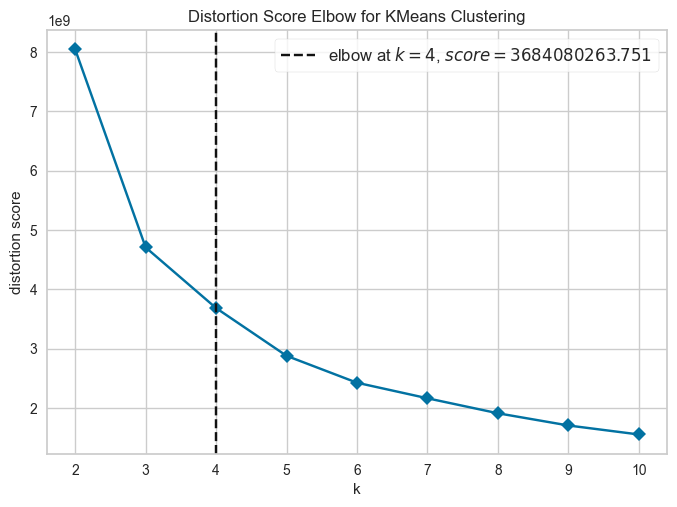

In [60]:
plot_model(kmeans, plot = 'elbow')

In [61]:
# plot_model(kmeans, plot = 'distribution')

In [62]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [63]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84116 entries, 0 to 84115
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84116 non-null  object
 1   date_              84116 non-null  object
 2   send_count         84116 non-null  Int64 
 3   impressions_count  84116 non-null  Int64 
 4   read_count         84116 non-null  Int64 
 5   activated_count    84116 non-null  Int64 
 6   conveted_count     84116 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [64]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.0,0.889878,0.679585,0.411384,0.221313
std,0.0,0.313043,0.466639,0.492088,0.415134
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [65]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [66]:
res.describe()

,M1_core_count,M1_ppob_count,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,send_count,impressions_count,read_count,activated_count,conveted_count
count,77672.0,77672.0,62494.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0
mean,26.273187,33.227791,44.31507,0.064138,386.900126,0.800704,0.719316,0.584086,1.0,0.889878,0.679585,0.411384,0.221313
std,96.174458,91.074844,95.818135,0.244999,326.858124,0.399474,0.449336,0.492882,0.0,0.313043,0.466639,0.492088,0.415134
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,3.0,0.0,79.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
50%,0.0,3.0,13.0,0.0,351.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
75%,9.0,29.0,45.0,0.0,639.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
max,3731.0,5160.0,2907.0,1.0,1418.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [67]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  total_customer  \
date_      Cluster                                                   
2023-05-01 Cluster 0        9.67806       29.23484        29.61276   
           Cluster 1      13.154244      27.364233       29.518403   
           Cluster 2      45.201238      27.783669          62.303   
           Cluster 3       31.06344       27.76913       46.437175   
2023-06-01 Cluster 0      13.002852      35.715779        34.86253   
           Cluster 1      12.758548       28.71415       30.757219   
           Cluster 2      38.178182      29.918909       54.599158   
           Cluster 3      28.422053      31.755088        44.65604   
2023-07-01 Cluster 0      14.641311      35.367466       37.829937   
           Cluster 1      11.352218      27.345279       32.569252   
           Cluster 2      47.812317       30.19481       62.644163   
           Cluster 3      29.882403      31.456795       48.065197   
2023-08-01 Cluster 0      21.726531      52.165986       46.364052   
           Cluster 1      18.371502      45.355255       39.145361   
           Cluster 2      69.920918      44.924532       78.391726   
           Cluster 3      39.350295      46.987733       55.665487   

                      is_referrer  age_on_platform_days  is_send_m1  \
date_      Cluster                                                    
2023-05-01 Cluster 0     0.049462           1031.976344    0.869892   
           Cluster 1     0.035142             87.031073    0.968927   
           Cluster 2     0.098404            743.576368    0.742401   
           Cluster 3     0.060501            444.477528    0.780467   
2023-06-01 Cluster 0     0.036991           1046.636868    0.603576   
           Cluster 1     0.026894             76.763174    0.731993   
           Cluster 2      0.07749              757.6875    0.560213   
           Cluster 3     0.062057            464.592987     0.74606   
2023-07-01 Cluster 0     0.062284           1051.347174    0.786044   
           Cluster 1      0.03325              97.93099     0.96675   
           Cluster 2     0.145316            748.950897    0.543214   
           Cluster 3     0.076014            500.703203    0.609964   
2023-08-01 Cluster 0     0.087392           1061.873249    0.862575   
           Cluster 1     0.046917             113.39377    0.959186   
           Cluster 2     0.168919             751.39147    0.880701   
           Cluster 3      0.08403            495.771403    0.889767   

                      is_imp_m1  is_read_m1  send_count  impressions_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0   0.835484    0.705376         1.0           0.951613   
           Cluster 1    0.85709    0.731936         1.0           0.876079   
           Cluster 2   0.702508    0.593085         1.0            0.94035   
           Cluster 3   0.708297    0.584054         1.0           0.900173   
2023-06-01 Cluster 0   0.579531    0.480888         1.0            0.95561   
           Cluster 1   0.647412    0.549033         1.0           0.878859   
           Cluster 2   0.530742    0.441311         1.0           0.939024   
           Cluster 3   0.674744    0.542356         1.0           0.898148   
2023-07-01 Cluster 0   0.746828    0.585928         1.0           0.934833   
           Cluster 1   0.845355    0.667763         1.0           0.858602   
           Cluster 2   0.509331    0.392825         1.0           0.915383   
           Cluster 3   0.544911    0.415231         1.0           0.879715   
2023-08-01 Cluster 0   0.811207    0.663109         1.0           0.929953   
           Cluster 1   0.847044    0.692435         1.0           0.866879   
           Cluster 2   0.809966    0.632179         1.0           0.910473   
           Cluster 3   0.786311    0.613282         1.0           0.869663   

                      read_count  activated_count  conveted_count  
date_    

In [68]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0       930           930            907            907   
           Cluster 1      8110          8110           7929           7929   
           Cluster 2      2632          2632           2584           2584   
           Cluster 3      4628          4628           4587           4587   
2023-06-01 Cluster 0      1622          1622           1052           1052   
           Cluster 1     12828         12828           9505           9505   
           Cluster 2      3936          3936           2750           2750   
           Cluster 3      5076          5076           4471           4471   
2023-07-01 Cluster 0      1734          1734           1709           1709   
           Cluster 1     11549         11549          11385          11385   
           Cluster 2      5519          5519           5472           5472   
           Cluster 3      7025          7025           6990           6990   
2023-08-01 Cluster 0      1499          1499           1470           1470   
           Cluster 1      7865          7865           7755           7755   
           Cluster 2      4736          4736           4704           4704   
           Cluster 3      4427          4427           4402           4402   

                      total_customer  is_referrer  acquisition_channel  \
date_      Cluster                                                       
2023-05-01 Cluster 0             674          930                  930   
           Cluster 1            6738         8110                 8110   
           Cluster 2            2000         2632                 2632   
           Cluster 3            3653         4628                 4628   
2023-06-01 Cluster 0             822         1622                 1622   
           Cluster 1            7480        12828                12828   
           Cluster 2            2138         3936                 3936   
           Cluster 3            3576         5076                 5076   
2023-07-01 Cluster 0            1276         1734                 1734   
           Cluster 1            7877        11549                11549   
           Cluster 2            4266         5519                 5519   
           Cluster 3            5307         7025                 7025   
2023-08-01 Cluster 0            1313         1499                 1499   
           Cluster 1            7189         7865                 7865   
           Cluster 2            4230         4736                 4736   
           Cluster 3            3955         4427                 4427   

                      user_segment_sub_bucket  age_on_platform_days  \
date_      Cluster                                                    
2023-05-01 Cluster 0                      930                   930   
           Cluster 1                     8110                  8110   
           Cluster 2                     2632                  2632   
           Cluster 3                     4628                  4628   
2023-06-01 Cluster 0                     1622                  1622   
           Cluster 1                    12828                 12828   
           Cluster 2                     3936                  3936   
           Cluster 3                     5076                  5076   
2023-07-01 Cluster 0                     1734                  1734   
           Cluster 1                    11549                 11549   
           Cluster 2                     5519                  5519   
           Cluster 3                     7025                  7025   
2023-08-01 Cluster 0                     1499                  1499   
           Cluster 1                     7865                  7865   
           Cluster 2                     4736                  4736   
           Cluster 3                     4427                  4427   

     